# Problem Description

Iris dataset is a well-known three-class (`Setosa`, `Versicolour` and `Virginica`) flower dataset containing labeled samples characterized by four features: `sepal length (cm)`, `sepal width (cm)`, `petal length (cm)` and `petal width (cm)`.

The Iris dataset is widely used as an entry-level classification dataset in machine learning. One of its interesting property is that the `Setosa` category is easily separable from the other two categories, while distinguishing `Versicolour` from `Virginica` is more challenging. I will demonstrate the distribution of dataset across different features to visualize this interesting property.

The primary goal of this project is to build a general-purpose binary SVM classifier using GAMSPy. This classifier is designed to solve both the primal and dual formulations of SVM and handle linear as well as non-linear kernels. 

This notebook initially served as a course project report of CS524 (Introduction to Optimization) at Univerisity of Wisconsin-Madison, under the supervision of Professor Michael Ferris.

Deliverables:
- A complete version of `BinarySVM` class, supporting hard-margin SVM, soft-margin SVM, polynomial kernel SVM and RBF kernel SVM. This implementation is ready-to-import for any user
- An automated hyperparameter tuning process

# Download Dependencies

In [ ]:
# other than gamspy, please install the following packages
! pip install numpy pandas matplotlib seaborn

# sklearn provides the iris dataset, and feature augmentation
! pip install scikit-learn

In [2]:
# this notebook depends on mosek solver
!python -m gamspy install solver mosek

  Using cached gamspy_mosek-48.6.0-py3-none-win_amd64.whl.metadata (60 bytes)
Using cached gamspy_mosek-48.6.0-py3-none-win_amd64.whl (8.6 MB)
  Attempting uninstall: gamspy-mosek
    Found existing installation: gamspy_mosek 48.6.0
    Uninstalling gamspy_mosek-48.6.0:
      Successfully uninstalled gamspy_mosek-48.6.0
`mosek` already exists in the capabilities file, skipping


# Load Dependency Packages
This project used `gamspy.math.matrix.dim` to define domains instead of using `Set`. I found this feature particularly convenient for machine learning tasks, as it simplifies the process of handling the feature dimensions and the data dimensions. I found that GAMSPy highlighted this newly added feature when reading through its documentation [GAMSPy and Machine Learning](https://gamspy.readthedocs.io/en/latest/user/ml/logistic.html).

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

import gamspy as gp
from gamspy import Container, Problem, Sense, Sum
import gamspy.math as gpm
from gamspy.math.matrix import dim


from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import pairwise_distances

mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2
solver = "mosek"

# Load Iris Dataset

This dataset consists of 150 samples, with 50 samples per category. The category labels are stored in the `species` column. In the initial setting, `Setosa`, `Versicolour` and `Virginica` samples are labeled as 0, 1 and 2 respectively. In later binary classification, the labels will be changed to ${+1, -1}$ at two different scenarios:
1. Classify `Setosa` from `Versicolour`: `Setosa` samples are labeled as $+1$ and `Versicolour` samples are labeled as $-1$
2. Classify `Versicolour` from `Virginica`: `Versicolour` samples are labeled as $+1$ and `Virginica` samples are labeled as $-1$

In [4]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["species"] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


## Visualize Dataset

The following subplots show that `Setosa` is easily separable from the other two categories, while `Versicolor` and `Virginica` are difficult to separate. The dataset is visualized using combinations of any two features and in a reduced-dimensional space obtained from Principal Component Analysis (PCA).

In [5]:
# standardize features, keep labels unchanged
scaler = StandardScaler()
scaled_data = scaler.fit_transform(iris_df.iloc[:, :-1])

# PCA: dimensional reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
pca_df["species"] = iris_df["species"]

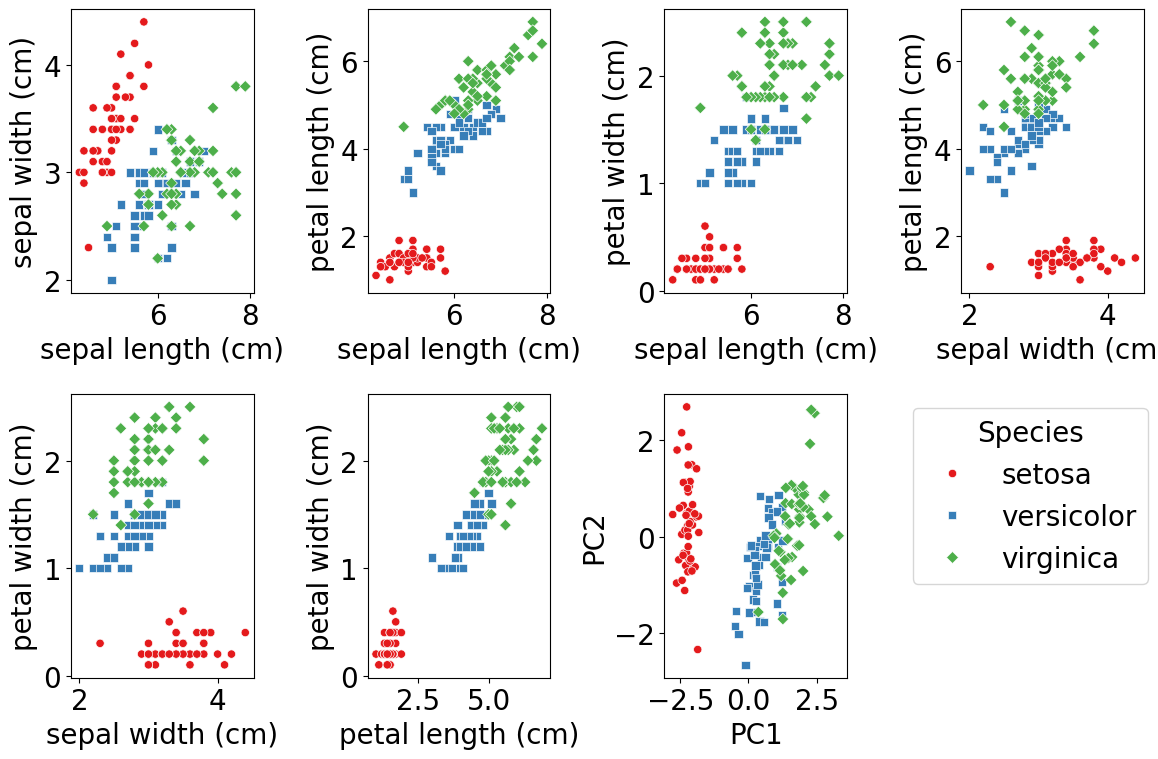

In [6]:
species_names = {0: "setosa", 1: "versicolor", 2: "virginica"}
feature_combinations = [
    ("sepal length (cm)", "sepal width (cm)"),
    ("sepal length (cm)", "petal length (cm)"),
    ("sepal length (cm)", "petal width (cm)"),
    ("sepal width (cm)", "petal length (cm)"),
    ("sepal width (cm)", "petal width (cm)"),
    ("petal length (cm)", "petal width (cm)")
]

plt.figure(figsize=(12, 8))
for i, (feature_x, feature_y) in enumerate(feature_combinations, 1):
    plt.subplot(2, 4, i)
    scatter = sns.scatterplot(data=iris_df, x=feature_x, y=feature_y, \
                hue="species", palette="Set1", style="species", markers=["o", "s", "D"], legend=False)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)

plt.subplot(2, 4, 7)
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
scatter.get_legend().remove()

plt.subplot(2, 4, 8)
plt.axis("off")
plt.legend(handles, labels, title="Species", loc="upper right", bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

# General SVM Class for Binary Classification

The following class `BinarySVM` takes the input data in `numpy.ndarray` format, solves the SVM classification using `GAMSPy`, and outputs prediction and evaluation results in `numpy.ndarray` format. 
1. `BinarySVM` supports primal formulations of SVM for hard-margin and soft-margin SVM.
2. `BinarySVM` supports dual formulations of SVM for linear/polynomial/rbf kernels.

Users can wrap the `BinarySVM` class in a py file such as `svm_binary.py`, which is ready to be imported as an independent module. This section only contains the definition of the `BinarySVM` class. I will show the mathematics of modeling in next section. 

In [7]:
class BinarySVM():
    def __init__(self, kernel="linear", use_slacking=True, \
            c=0, solver="cplex", problem="primal", **kargs):
        self.m = None
        self.n_features = None
        self.is_fit = False
        self.kernel = kernel
        self.use_slacking = use_slacking
        self.c = c
        self.w = None
        self.gamma = None
        self.delta = None
        self.j = None # place holder for number of features
        self.snapshot = (None, None)
        self.solver = solver
        self.kargs = kargs
        self.problem = problem
        assert self.kernel in ["linear", "polynomial", "rbf"], \
            f"{self.kernel} is not a valid kernel option"
        assert self.problem in ["primal", "dual"], \
            f"{self.problem} is not a valid problem option"
        

    def solve_primal(self, train_X, train_Y):
        """
        Primal problem
        """
        self.m = Container()
        self.C = self.m.addParameter("C",\
                description="slacking variable tradeoff")
        
        assert np.all(np.isin(train_Y, [1, -1])), "Labels should be {-1, 1}"
        
        n, n_features = train_X.shape
        self.n_features = n_features
        
        # parameters
        X = self.m.addParameter("train_X", domain=dim((n, n_features)), 
                              records=train_X)
        p = X.domain[0]
        self.j = X.domain[1]
        Y = self.m.addParameter("train_Y", domain=p, 
                              records=train_Y)
        # variables
        self.delta = self.m.addVariable("delta", "positive", \
                domain=p, description="slacking variable")
        self.w = self.m.addVariable("w", "free", domain=self.j, \
                description="coefficients of hyperplane")
        self.gamma = self.m.addVariable("gamma", "free", \
                description="bias of hyperplane")
        
        # constraints
        cons = self.m.addEquation("constraints", domain=p)
        cons[p] = Y[p]*(Sum(self.j, X[p, self.j]*self.w[self.j]) + self.gamma) + self.delta[p] >= 1
        
        # objective function
        objective = 0.5*Sum(self.j, gpm.sqr(self.w[self.j])) + self.C*Sum(p, self.delta[p])

        if self.use_slacking:
            self.C.setRecords(self.c)
            
        else:
            self.C.setRecords(0)
            self.delta.fx[p] = 0

        # model
        svm = self.m.addModel('svm',
            equations=[cons],
            problem=Problem.QCP,
            sense=Sense.MIN,
            objective=objective
        )

        svm.solve(solver=self.solver)
        self.is_fit = True
        self.snapshot = (self.w.records.level.values, self.gamma.records.level.values)
        return svm


    def _kernel_function(self, kernel, X1, X2):
        """
        phi(X1).T @ phi(X2)
        """
        if kernel == "linear":
            # XX^{T}: (n, n_features) @ (n_feature, n)
            K = X1@X2.T
        elif kernel == "polynomial":
            K = X1@X2.T
            K = K**self.kargs["d"]
        elif kernel == "rbf":
            pairwise_dists = pairwise_distances(X1, X2, metric="euclidean")
            K = np.exp(-pairwise_dists**2/(2*self.kargs["sigma"]**2))
        else:
            raise ValueError(f"{kernel} is not a valid kernel option")
        return K

        
    def solve_dual(self, train_X, train_Y):
        """
        Dual problem
        """
        self.m = Container()
        assert self.c>0, f"Invalid constant C: {self.c}"
        assert np.all(np.isin(train_Y, [1, -1])), "Labels should be {-1, 1}"
        n, n_features = train_X.shape
        self.n_features = n_features
        
        self.C = self.m.addParameter("C", description="upper bound for alpha", records=self.c)
        
        # parameters
        # introduce kernel
        self.X = self.m.addParameter("train_X", dim((n, n_features)),
                records=train_X)
        Phi = self._kernel_function(self.kernel, train_X, train_X)

        Q = train_Y.reshape(-1, 1).T @ train_Y.reshape(-1, 1) * Phi
        
        self.Q = self.m.addParameter("Q", domain=dim((n, n)), records=Q)
        p = self.Q.domain[0]
        self.Y = self.m.addParameter("train_Y", domain=p, 
                records=train_Y)
        
        # variables
        self.alpha = self.m.addVariable("alpha", "positive", \
                domain=p, description="lagrangian: alphas")
        # constraints
        cons1 = self.m.addEquation("constraint1", description="alpha.T * y = 0")
        cons1[:] = Sum(p, self.alpha[p]*self.Y[p]) == 0
        
        cons2 = self.m.addEquation("constraint2", domain=p, description="0<= alpha <= C")
        cons2[p] = self.alpha[p] <= self.C
        
        # objective function: the matrix operations are allowed when using 'dim'
        # objective = Sum(p, self.alpha) - 0.5 * Sum(q, Sum(p, self.alpha[p]* Q[p, q])*self.alpha[q])
        objective = Sum(p, self.alpha[p]) - 0.5 * self.alpha @ self.Q @ self.alpha
        
        # model
        svm = self.m.addModel('svm',
            equations=[cons1, cons2],
            problem=Problem.QCP,
            sense=Sense.MAX,
            objective=objective
        )

        svm.solve(solver=self.solver)
        self.is_fit = True
        # record alpha
        self.snapshot = self.alpha.records.level.values
        return svm       


    def solve(self, train_X, train_Y):
        # default solver
        if self.kernel == "linear" and self.problem == "primal":
            # use primal probelm to find linear solutions
            return self.solve_primal(train_X, train_Y)
        else:
            # use dual problem to find non-linear solutions
            return self.solve_dual(train_X, train_Y)


    def evaluate(self, test_X, test_Y):
        pred_Y = self.predict(test_X)
        acc = accuracy_score(test_Y, pred_Y)
        conf_matrix = confusion_matrix(test_Y, pred_Y)
        return acc, conf_matrix


    def predict_primal(self, test_X):
        if (self.is_fit is not True) or (self.m is None):
            raise ValueError("Model has not been fit yet")
        w, gamma = self.snapshot
        pred_Y = np.sum(w*test_X, axis=1) + gamma > 0
        pred_Y = np.where(pred_Y, 1, -1)
        return pred_Y

    
    def predict_dual(self, test_X):
        if (self.is_fit is not True) or (self.m is None):
            raise ValueError("Model has not been fit yet")
        alpha = self.snapshot
        train_X, train_Y = self.X.pivot().values, self.Y.records["value"].values
        
        # calculate w and b
        support_mask = alpha > 0
        support_alpha = alpha[support_mask]
        support_x = train_X[support_mask]
        support_y = train_Y[support_mask]
        # good_mask = alpha < 1e-6

        # wx = np.sum((alpha*train_Y).reshape(-1, 1) \
        #             * self._kernel_function(self.kernel, train_X, test_X), axis=0)
        wx = np.sum((support_alpha*support_y).reshape(-1, 1) \
                    * self._kernel_function(self.kernel, support_x, test_X), axis=0)
        
        pos = np.sum((support_alpha*support_y).reshape(-1, 1) \
            * self._kernel_function(self.kernel, support_x, train_X[(train_Y==1)]), axis=0)
        neg = np.sum((support_alpha*support_y).reshape(-1, 1) \
            * self._kernel_function(self.kernel, support_x, train_X[(train_Y==-1)]), axis=0)
        bias = -(np.max(neg)+np.min(pos))/2

        pred_y = wx + bias
        pred_y = np.sign(pred_y)
        return np.array(pred_y)


    def predict(self, test_X):
        if self.kernel == "linear" and self.problem == "primal":
            return self.predict_primal(test_X)
        else:
            return self.predict_dual(test_X)

# Models

## Primal Problem

The dataset is denoted as $\{\mathbf{x_{i}}, y_{i}\}_{i=1}^{n}$. The primal optimization problem for soft-margin SVM binary classification is defined as 
$$
min\, f(x)=\frac{1}{2}w^{T}w + C\sum_{i=1}^{n}\delta_{i}
$$

$$
s.t.\,  y_{i}*(w^{T}\mathbf{x_{i}}+\gamma) + \delta_{i} >= 1, \delta_{i}\ge 0
$$

Especially, when $C=0$, the soft-margin SVM becomes hard-margin SVM:
$$
min\, f(x)=\frac{1}{2}w^{T}w + 0*\sum_{i=1}^{n}\delta_{i} = \frac{1}{2}w^{T}w
$$

$$
s.t.\,   y_{i}*(w^{T}\mathbf{x_{i}}+\gamma) + \delta_{i} >= 1, 
\delta_{i} == 0
$$

When using the trained model to predict new datapoints:
$$
\hat{y} = sign(w^{T}x + \gamma)
$$

### Hard-margin SVM
This validation will be done on classifying `Setosa` from `Versicolor`. These two classes are linearly separable. 

The class is designed to set the "misclassification" constant $C$ as 0 as long as the `use_slacking` is disabled, in order to turn off "misclassification" possibilities. The linear boundary can vary on different train/validation split.

In [8]:
scaled_data = pca_df.values
N = scaled_data.shape[0]
train_indices, test_indices = train_test_split(range(N), test_size=0.2)

scaled_data_train = scaled_data[train_indices]
scaled_data_test = scaled_data[test_indices]

# training data
train_X_Setosa = scaled_data_train[:, :-1][scaled_data_train[:, -1] == 0]
train_X_Versicolor = scaled_data_train[:, :-1][scaled_data_train[:, -1] == 1]
train_X = np.vstack([train_X_Setosa, train_X_Versicolor])
train_Y = [1]*train_X_Setosa.shape[0] + [-1]*train_X_Versicolor.shape[0]
train_Y = np.array(train_Y)


# test data
test_X_Setosa = scaled_data_test[:, :-1][scaled_data_test[:, -1] == 0]
test_X_Versicolor = scaled_data_test[:, :-1][scaled_data_test[:, -1] == 1]
test_X = np.vstack([test_X_Setosa, test_X_Versicolor])
test_Y = [1]*test_X_Setosa.shape[0] + [-1]*test_X_Versicolor.shape[0]
test_Y = np.array(test_Y)

# model: training
hard_margin_model = BinarySVM(kernel="linear", use_slacking=False,  c=0, solver=solver)
hard_svm = hard_margin_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(hard_svm.objective_value, 4))
print("status: ", hard_svm.status)
print("solver status: ", hard_svm.solve_status)


# evaluate using test data
train_acc, train_conf_matrix = hard_margin_model.evaluate(train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = hard_margin_model.evaluate(test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)

Objective Function Value:  1.077
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Accuracy on train set: 100.000 %
Confusion matrix for train set: [[44  0]
 [ 0 39]]
Accuracy on test set: 100.000 %
Confusion matrix for test set: [[ 6  0]
 [ 0 11]]


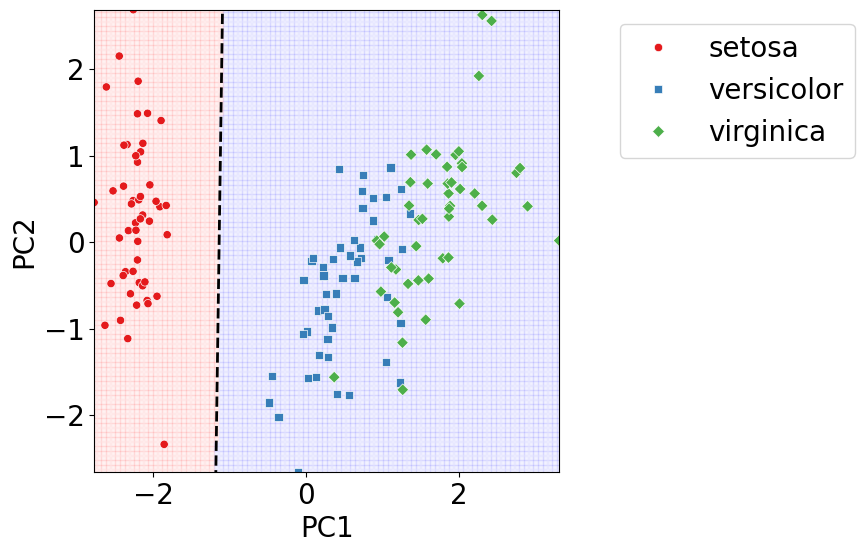

In [9]:
# visualize training and test prediction
color_map = {1: "red", -1: "blue"}
w, gamma = hard_margin_model.snapshot

# plot boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = -w[0]/w[1]*bg_x -gamma/w[1]
plt.plot(bg_x, bg_y, "k--")

# plot backgorund
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
pred_grid_y = hard_margin_model.predict(grids)
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# plot datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

The background color in the the above figure shows the predicted decision boundary, and the dashed black line is built by the parameters of $w$ and $\gamma$. It is apparently `Setosa` and `Versicolor` are well separated using the hard-margin SVM.

### Soft-margin SVM

#### Classify `Setosa` and `Versicolor`
These two classes are linearly separable. Even though the class allows "misclassification" possibilities, ideally the $\delta_{i}$ should be close enough to $0$.

In [10]:
# model: training
soft_margin_model = BinarySVM(kernel="linear", use_slacking=True,  c=1, solver=solver)
soft_svm = soft_margin_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(soft_svm.objective_value, 4))
print("status: ", soft_svm.status)
print("solver status: ", soft_svm.solve_status)

delta = soft_margin_model.delta.records.level.values
print("Slacking variable should be close to 0 in this scenario:", np.max(np.abs(delta)))

# evaluate using test data
train_acc, train_conf_matrix = soft_margin_model.evaluate(train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = soft_margin_model.evaluate(test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)


Objective Function Value:  1.0738
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Slacking variable should be close to 0 in this scenario: 0.04955908904827893
Accuracy on train set: 100.000 %
Confusion matrix for train set: [[44  0]
 [ 0 39]]
Accuracy on test set: 100.000 %
Confusion matrix for test set: [[ 6  0]
 [ 0 11]]


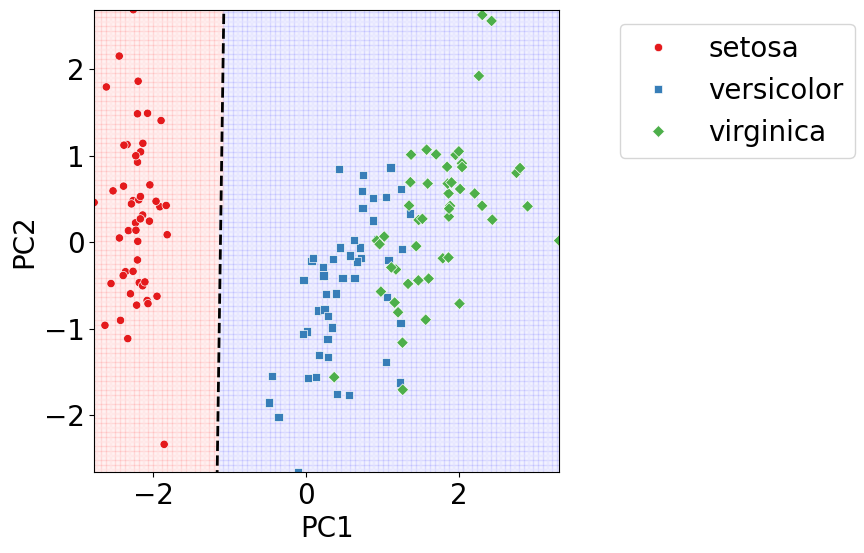

In [11]:
# visualize training and test prediction
color_map = {1: "red", -1: "blue"}
w, gamma = soft_margin_model.snapshot

# plot linear boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = -w[0]/w[1]*bg_x -gamma/w[1]
plt.plot(bg_x, bg_y, "k--")

# plot backgorund
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
pred_grid_y = soft_margin_model.predict(grids)
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

The solution of soft-margin SVM and hard-margin SVM are very close when distinguishing `Setosa` from `Versicolor`Moreover, the slacking variables $\delta_{i}$ is very close to $0$. These two phenomenon are both expected.

In both soft-margin SVM and hard-margin SVM, the prediction achieves $100\%$ accuracy indicating `Setosa` and `Versicolor` are perfectly separable.

#### Classify `Versicolor` and `Virginica`
These two classes are not linearly separable. This classification cannot be solved using hard-margin SVM. Even though it can be solved after introducing slacking variables in the soft-margin SVM, the prediction accuracy cannot be perfect.

In [12]:
scaled_data = pca_df.values
N = scaled_data.shape[0]
train_indices, test_indices = train_test_split(range(N), test_size=0.2)

scaled_data_train = scaled_data[train_indices]
scaled_data_test = scaled_data[test_indices]

# training data
train_X_Versicolor = scaled_data_train[:, :-1][scaled_data_train[:, -1] == 1]
train_X_Virginica = scaled_data_train[:, :-1][scaled_data_train[:, -1] == 2]
train_X = np.vstack([train_X_Versicolor, train_X_Virginica])
train_Y = [1]*train_X_Versicolor.shape[0] + [-1]*train_X_Virginica.shape[0]
train_Y = np.array(train_Y)


# test data
test_X_Versicolor = scaled_data_test[:, :-1][scaled_data_test[:, -1] == 1]
test_X_Virginica = scaled_data_test[:, :-1][scaled_data_test[:, -1] == 2]
test_X = np.vstack([test_X_Versicolor, test_X_Virginica])
test_Y = [1]*test_X_Versicolor.shape[0] + [-1]*test_X_Virginica.shape[0]
test_Y = np.array(test_Y)

# model: training
soft_margin_model = BinarySVM(kernel="linear", use_slacking=True, c=1, solver=solver)
soft_svm = soft_margin_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(soft_svm.objective_value, 4))
print("status: ", soft_svm.status)
print("solver status: ", soft_svm.solve_status)


# evaluate using test data
train_acc, train_conf_matrix = soft_margin_model.evaluate(train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = soft_margin_model.evaluate(test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)

Objective Function Value:  25.862
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Accuracy on train set: 86.585 %
Confusion matrix for train set: [[36  4]
 [ 7 35]]
Accuracy on test set: 88.889 %
Confusion matrix for test set: [[9 1]
 [1 7]]


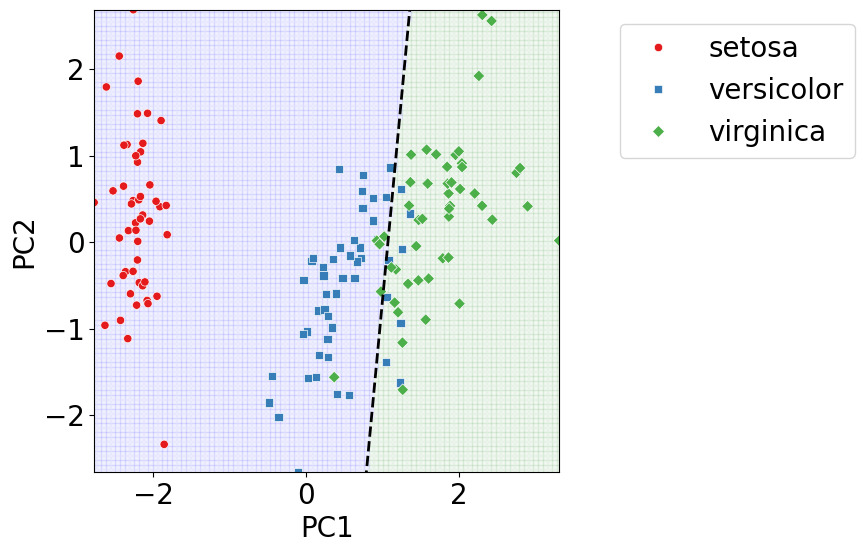

In [13]:
# visualize training and test prediction
color_map = {1: "blue", -1: "green"}
w, gamma = soft_margin_model.snapshot

# plot linear boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = -w[0]/w[1]*bg_x -gamma/w[1]
plt.plot(bg_x, bg_y, "k--")

# background
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
pred_grid_y = soft_margin_model.predict(grids)
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# plot datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

The accuracy of training and test set is is not $100\%$. It is impossible to find a perfect linear boundary to distinguish `Versicolor` from `Virginica`. The following block shows an attempt to classify `Versicolor` from `Virginica` using hard-margin SVM, but the model is infeasible.

In [14]:
attempted_model = BinarySVM(kernel="linear", use_slacking=False, c=0, solver=solver)
attempted_svm = attempted_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(attempted_svm.objective_value, 4))
print("status: ", attempted_svm.status)
print("solver status: ", attempted_svm.solve_status)

Objective Function Value:  0.0
status:  ModelStatus.InfeasibleGlobal
solver status:  SolveStatus.NormalCompletion


### Use Parametric tricks to implement non-linearity

Continuing with the `Versicolor` vs. `Virginica` scenario, one possible approach to incorporating non-linearity is by using non-linear transformations on the original features, such as a polynomial kernel. 

The following blocks firstly include additional polynomial terms to $\mathbf{x_{i}}$ by `PolynomialFeatures`, and use soft-margin SVM to fit on the transformed dataset. For example, when $d=2$, feature vector $\mathbf{x}=(x_1, x_2, \dots, x_{n})$  will be expanded to $\mathbf{x}'=(1, x_1, x_2, \dots, x_{n}, x_1x_2, x_1x_3, \dots, x_{n-1}x_{n})$. The decision boundary between the two classes becomes non-linear accordingly.

In [15]:
polynomial_model = BinarySVM(kernel="linear", use_slacking=True,  c=1, solver=solver)

poly = PolynomialFeatures(degree=3)
poly_train_X = poly.fit_transform(train_X)
poly_test_X = poly.fit_transform(test_X)

polynomial_svm = polynomial_model.solve(poly_train_X, train_Y)
print("Objective Function Value: ", round(polynomial_svm.objective_value, 4))
print("status: ", polynomial_svm.status)
print("solver status: ", polynomial_svm.solve_status)

# evaluate using test data
train_acc, train_conf_matrix = polynomial_model.evaluate(poly_train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = polynomial_model.evaluate(poly_test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)

Objective Function Value:  19.9292
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Accuracy on train set: 86.585 %
Confusion matrix for train set: [[36  4]
 [ 7 35]]
Accuracy on test set: 88.889 %
Confusion matrix for test set: [[9 1]
 [1 7]]


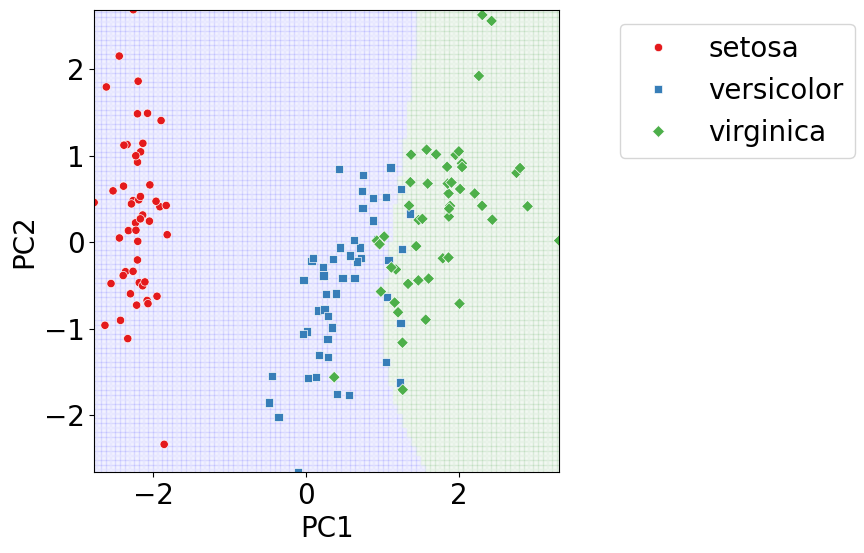

In [16]:
# visualize training and test prediction
color_map = {1: "blue", -1: "green"}

# plot boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)

grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
poly = PolynomialFeatures(degree=3)
poly_X = poly.fit_transform(grids)
pred_grid_y = polynomial_model.predict(poly_X)

plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# plot datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

## Dual Problem

Recall the primal problem, 

$$
min\, f(x)=\frac{1}{2}w^{T}w + C\sum_{i=1}^{n}\delta_{i}
$$
$$
s.t.\, y_{i}*(w^{T}\mathbf{x_{i}}+\gamma) + \delta_{i} >= 1, \delta_{i}\ge 0
$$

We can define a Lagrangian function,
$$
L(x, \alpha, \beta) = f(x) -\sum_{i=1}^{n} \alpha_{i}(y_{i}(w^{T}\phi(x_{i})+\gamma)+\delta_{i}-1) - \sum_{i=1}^{n} \beta_{i}\delta_{i}
$$

$$
=\frac{1}{2}w^{T}w + C\sum_{i=1}^{n}\delta_{i}-\sum_{i=1}^{n} \alpha_{i} (y_{i}w^{T}\phi(x_{i})+y_{i}\gamma+\delta_{i}-1) - \sum_{i=1}^{n} \beta_{i}\delta_{i}
$$

$$
= \frac{1}{2}w^{T}w + \sum_{i=1}^{n}\delta_{i} (C-\alpha_{i}-\beta_{i})
-\sum_{i=1}^{n} \alpha_{i}y_{i}w^{T}(\phi(x_{i}))
-\sum_{i=1}^{n} \alpha_{i}(y_{i}\gamma)
+ \sum_{i=1}^{n} \alpha_{i}
$$

Plugin the following stationary conditions from KKT to the Lagrangian function,

$$
\text{Eqn 1: }\frac{\partial L}{\partial w} = w-\sum_{i=1}^{n}\alpha_{i}y_{i}\phi(x_{i}) = 0
$$

$$
\Rightarrow w = \sum_{i=1}^{n}\alpha_{i}y_{i}\phi(x_{i})
$$

$$
\text{Eqn 2: }\frac{\partial L}{\partial \delta_{i}} = C - \alpha_{i} - \beta_{i} = 0
$$

$$
\text{Eqn 3: }\frac{\partial L}{\partial \gamma} = -\sum_{i=1}^{n} \alpha_{i}y_{i} = 0
$$
<!-- $$
\Rightarrow -\sum_{i=1}^{n} \alpha_{i}y_{i} \sum_{j=1}^{n} \alpha_{j}y_{j} \phi(x_{j}) = 0
$$ -->

We have the Lagrangian function as:
$$
L(x, \alpha, \beta) = -\frac{1}{2} \sum_{i=1}^{n} \alpha_{i}y_{i}\phi(x_{i})^{T} \sum_{j=1}^{n} \alpha_{j}y_{j} \phi(x_{j}) + \sum_{i=1}^{n}\alpha_{i} \\
= -\frac{1}{2}\alpha^{T} Q \alpha + \sum_{i=1}^{n} \alpha_{i}
$$

Therefore, the dual problem can be formulated as:
$$
max\, -\frac{1}{2}\alpha^{T} Q \alpha + \sum_{i=1}^{n} \alpha_{i}
$$

$$
s.t.\, 0\le \alpha_{i} \le C\\
y^{T}\alpha = 0
$$

$Q_{ij}$ is a shorthand for $y_{i}y_{j}K(x_{i}, x_{j})$, and $K(x_{i}, x_{j})$ is the kernel function. The following kernels are used in this project:
1. Linear: $K(x_{i}, x_{j})= x_{i}^{T}x_{j}$
2. Polynomial: $K(x_{i}, x_{j})= (x_{i}^{T}x_{j})^d$
3. Radial basis function (rbf): $K(x_{i}, x_{j})= \exp(-\|(x_{i}-x_{j})\|^{2}/2\sigma^{2})$

This section continues to work on classifying `Versicolor` from `Virginica`. The following blocks utilizes the linear/polynomial/rbf kernel respectively in the dual problem.



When using the trained dual model to predict new datapoints, the decision boundary of the linear kernel is reconstructed using the following equation:
$$
\hat{y}=sign(w^{T}\phi(x)+\gamma) = sign(\sum_{i=1}^{n}\alpha_{i}y_{i}\phi(x_{i})^{T}\phi(x)+\gamma)
$$

Since training datapoints with $\alpha_{i}=0$ are correctlt separated by the model and do not contribute to $\sum_{i=1}^{n}\alpha_{i}y_{i}\phi(x_{i})^{T}\phi(x)$, the above inferrence equation can be re-formulated using the `support vectors` with $\alpha_{j} > 0$:

$$
\hat{y}=sign(w^{T}\phi(x)+\gamma) = sign(\sum_{j=1}^{n}\alpha_{j}y_{j}\phi(x_{j})^{T}\phi(x)+\gamma)
$$

$\gamma$ is reconstructed using 
$$
\gamma = -\frac{max_{i: y_{i}=-1}w^{T}x + min_{i: y_{i}=1}w^{T}x}{2}
$$

### Linear kernel

In [17]:
# model: training
linear_kernel_model = BinarySVM(kernel="linear", c=1, solver=solver, problem="dual")
linear_svm = linear_kernel_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(linear_svm.objective_value, 4))
print("status: ", linear_svm.status)
print("solver status: ", linear_svm.solve_status)


# evaluate using test data
train_acc, train_conf_matrix = linear_kernel_model.evaluate(train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = linear_kernel_model.evaluate(test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)

Objective Function Value:  0.0257
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Accuracy on train set: 79.268 %
Confusion matrix for train set: [[38  2]
 [15 27]]
Accuracy on test set: 83.333 %
Confusion matrix for test set: [[10  0]
 [ 3  5]]


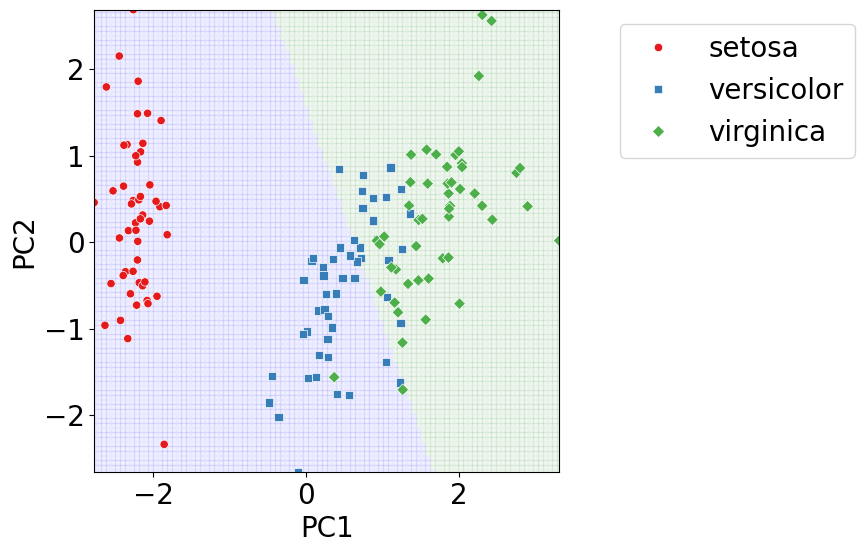

In [18]:
# visualize training and test prediction
color_map = {1: "blue", -1: "green"}

# plot boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)

# plot backgorund
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
pred_grid_y = linear_kernel_model.predict(grids)
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# plot datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

Ideally, the objective function of the dual problem and the primal problem should be the same, and the two problems should have the same solution. However, the linear kernel SVM results in a different linear decision boundary compared to the soft-margin SVM. The objective functions are also different.

I think the decision boundary from the soft-margin SVM makes more sense because it leads to better separations of `Versicolor` and `Virginica` by eye as well as by a higher test accuracy.

### Polynomial kernel

In [19]:
# model: training
polynomial_kernel_model = BinarySVM(kernel="polynomial", use_slacking=True, \
    c=1, solver=solver, problem="dual", d=3)
polynomial_svm = polynomial_kernel_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(polynomial_svm.objective_value, 4))
print("status: ", polynomial_svm.status)
print("solver status: ", polynomial_svm.solve_status)


# evaluate using test data
train_acc, train_conf_matrix = polynomial_kernel_model.evaluate(train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = polynomial_kernel_model.evaluate(test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)

Objective Function Value:  0.04
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Accuracy on train set: 86.585 %
Confusion matrix for train set: [[33  7]
 [ 4 38]]
Accuracy on test set: 77.778 %
Confusion matrix for test set: [[8 2]
 [2 6]]


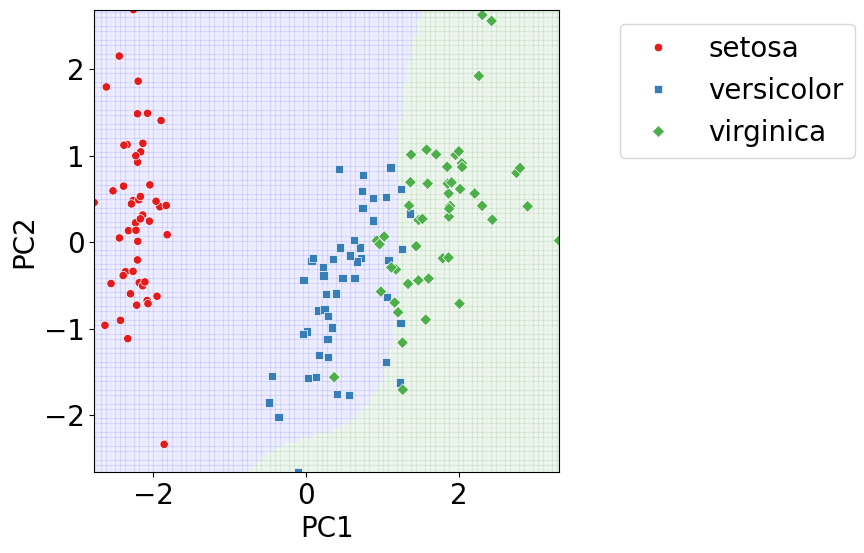

In [20]:
# visualize training and test prediction
color_map = {1: "blue", -1: "green"}

# plot boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)

# plot backgorund
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
pred_grid_y = polynomial_kernel_model.predict(grids)
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# plot datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

### RBF kernel

In [21]:
# model: training
rbf_kernel_model = BinarySVM(kernel="rbf", use_slacking=True,  c=1, \
    solver=solver, problem="dual", sigma=1)
rbf_svm = rbf_kernel_model.solve(train_X, train_Y)
print("Objective Function Value: ", round(rbf_svm.objective_value, 4))
print("status: ", rbf_svm.status)
print("solver status: ", rbf_svm.solve_status)


# evaluate using test data
train_acc, train_conf_matrix = rbf_kernel_model.evaluate(train_X, train_Y)
print(f"Accuracy on train set: {train_acc*100:.3f} %")
print("Confusion matrix for train set:", train_conf_matrix)

test_acc, test_conf_matrix = rbf_kernel_model.evaluate(test_X, test_Y)
print(f"Accuracy on test set: {test_acc*100:.3f} %")
print("Confusion matrix for test set:", test_conf_matrix)

Objective Function Value:  0.0277
status:  ModelStatus.OptimalGlobal
solver status:  SolveStatus.NormalCompletion
Accuracy on train set: 86.585 %
Confusion matrix for train set: [[39  1]
 [10 32]]
Accuracy on test set: 88.889 %
Confusion matrix for test set: [[10  0]
 [ 2  6]]


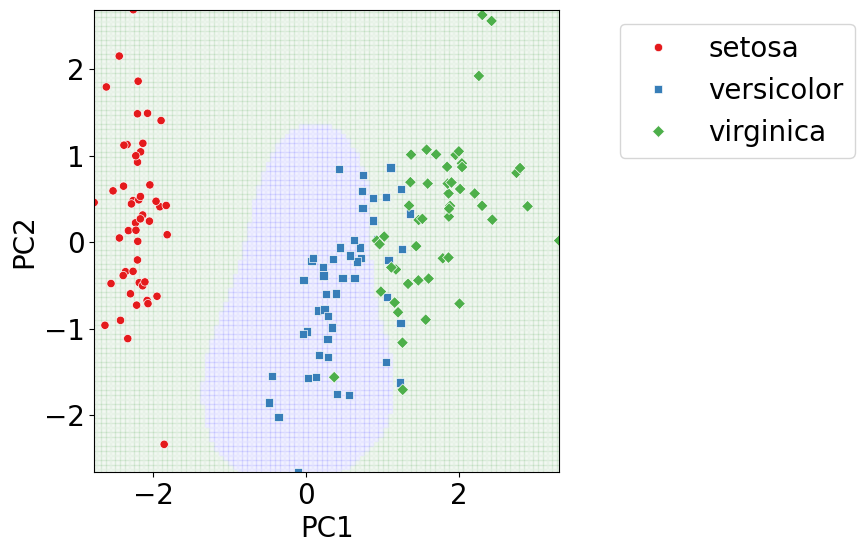

In [22]:
# visualize training and test prediction
color_map = {1: "blue", -1: "green"}

# plot boundary
plt.figure(figsize=(6, 6))
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)

# plot backgorund
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])
pred_grid_y = rbf_kernel_model.predict(grids)
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)

# plot datapoints
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

The nonlinear boundary obtained from polynomial kernel and rbf kernel both look reasonable to me.

# Cross-Validation

This section will show how to automatically select most appropriate hyperparameter `C` and kernel-specific hyperparameter (`d` in polynomial kernel and `sigma` in rbf kernel). The cross-validation are performed on the `Versicolor` vs. `Virginica` scenario using the PCA reduced dataset.

In [23]:
def hyperparam_cv(Model, X, Y, n_splits=5, normalize=False, **kargs):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    acc_lst = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        if normalize:
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
        try:
            model = Model(**kargs)
            svm = model.solve(X_train, Y_train)
            if ("OptimalLocal" in str(svm.status)) \
                or ("OptimalGlobal" in str(svm.status)):
                acc, _ = model.evaluate(X_val, Y_val)
                acc_lst.append(acc)
        except:
            continue
    avg = np.mean(acc_lst)
    return avg

In [24]:
scaled_data = pca_df.values
N = scaled_data.shape[0]

X_Versicolor = scaled_data[:, :-1][scaled_data[:, -1] == 1]
X_Virginica = scaled_data[:, :-1][scaled_data[:, -1] == 2]
X = np.vstack([X_Versicolor, X_Virginica])
Y = [1]*X_Versicolor.shape[0] + [-1]*X_Virginica.shape[0]
Y = np.array(Y)

## Hyperparameter Tuning for parametric trick

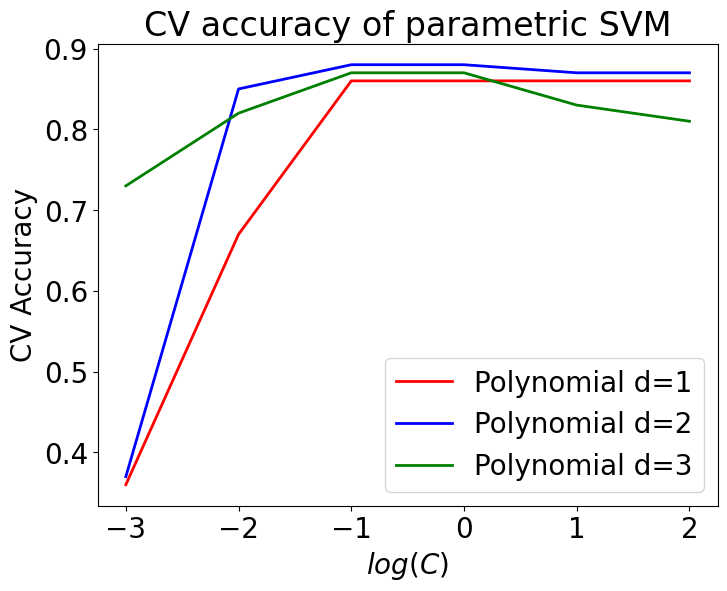

In [25]:
c_trialvals = [0.001, 0.01, 0.1, 1, 10, 100]
d_trialvals = [1, 2, 3]
normalize = False

partial_fn = partial(hyperparam_cv, \
    Model=BinarySVM, n_splits=5, normalize=normalize)

cv_results = {}
for d in d_trialvals:
    lst = []
    for c in c_trialvals:
        try:
            poly = PolynomialFeatures(degree=d)
            poly_X = poly.fit_transform(X)
            avg = partial_fn(kernel="linear", X=poly_X, Y=Y, \
                use_slacking=True, c=c, solver=solver, problem="primal")
        except:
            avg = None
        lst.append(avg)
    cv_results[d] = lst

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("CV accuracy of parametric SVM")
ax.set_xlabel("$log(C)$")
ax.set_ylabel("CV Accuracy")
colors = ["r", "b", "g"]
for d, color in zip(d_trialvals, colors):
    ax.plot(np.log10(c_trialvals), cv_results[d], \
        c=color, linestyle="-", label=f"Polynomial d={d}")
plt.legend()

## Hyperparameter Tuning for polynomial kernel

[MODEL - WARNING] The solve was interrupted! Solve status: TerminatedBySolver. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.
[MODEL - WARNING] The solve was interrupted! Solve status: TerminatedBySolver. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


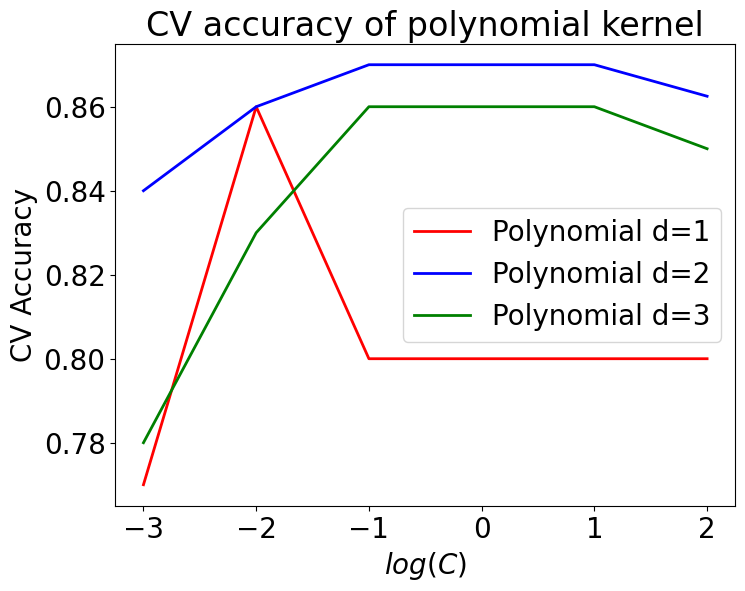

In [26]:
c_trialvals = [0.001, 0.01, 0.1, 1, 10, 100]
d_trialvals = [1, 2, 3]
normalize = False

partial_fn = partial(hyperparam_cv, \
    Model=BinarySVM, X=X, Y=Y, n_splits=5, normalize=normalize)

cv_results = {}
for d in d_trialvals:
    lst = []
    for c in c_trialvals:
        try:
            avg = partial_fn(kernel="polynomial", c=c, solver=solver, problem="dual", d=d)
        except:
            avg = None
        lst.append(avg)
    cv_results[d] = lst

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("CV accuracy of polynomial kernel")
ax.set_xlabel("$log(C)$")
ax.set_ylabel("CV Accuracy")
colors = ["r", "b", "g"]
for d, color in zip(d_trialvals, colors):
    ax.plot(np.log10(c_trialvals), cv_results[d], c=color, linestyle="-", label=f"Polynomial d={d}")
plt.legend()

When augmenting each feature vector $x_{i}$ using polynomial terms and solve a soft-margin SVM on the transformed dataset, the best hyperparameter combination is $C=0.1, d=2$ based on cross validation. The highest model accuracy on the test dataset is $88.00\%$ under this setting.

When using polynomial kernels and solve a dual SVM, the best hyperparameter combination is also $C=0.1, d=2$ based on cross validation. The highest model accuracy on the test dataset is $86.99\%$ under this setting, comparable to the accuracy from parametric tricks. 

# Conclusions

In conclusion, this notebook implements SVM classifier for binary classification using GAMSPy. 

The classifier is used to classify the Iris dataset. The hard-margin SVM and soft-margin SVM works equally well on perfectly separating `Setosa` from `Versicolor` because these two classes are linearly separable. The hard-margin SVM fails to work on classifying `Versicolor` from `Virginica` becase these two classes are not linearly separable. But with slacking variables in the soft-margin SVM, the model can predict `Versicolor` and `Virginica` with some misclassification error.

The majority effort of this notebook has been devoted to using non-linear kernels to help separate `Versicolor` from `Virginica`. The non-linearity can be introduced (1) by a non-linear transformation of input features and solving the primal problem, or (2) by introducing a non-linear kernel and solving the dual problem.

Personally, I think the parametric trick appears as a more convenient and more interpretable choice, especially for this small dataset. After transforming the input features to higher dimensions, the soft-margin SVM still gives an explicit parameter $w$ and bias $\gamma$ on the new dimensional space. However, when using the dual problem, the parameter and bias need to be reconstructed from $\alpha$, which is less straightforward. Moreover, based on the cross validation results, the dual problem using non-linear kernel does not outperform the combination of using parametric trick and soft-margin SVM. I am also worried about that my current implementation of the dual problem is buggy, because the objective function of linear kernel SVM does not equal to its primal problem (soft-margin SVM).

However, the kernel method has its own advantages. For example, the rbf kernel $K(x_{i}, x_{j})= \exp(-\|(x_{i}-x_{j})\|^{2}/2\sigma^{2})$ is difficult to decompose as the product of $\phi(x_{i})^{T}\phi(x_{j})$. Therefore, the kernel method can capture additional correlation between two datapoints, which is beyond higher-order expansion of a single datapoint.

Finnaly, I will wrap up results obtained from all above blocks and provide a full picture of decision boundaries for the whole Iris dataset. Even though this report performs the SVM on the PCA reduced dataset for easier visualization purposes, I want to emphasize that the `BinarySVM` class is designed for general purposes that supports arbitary feature dimensions and arbitray number of datapoints as long as within the solvers' capability.

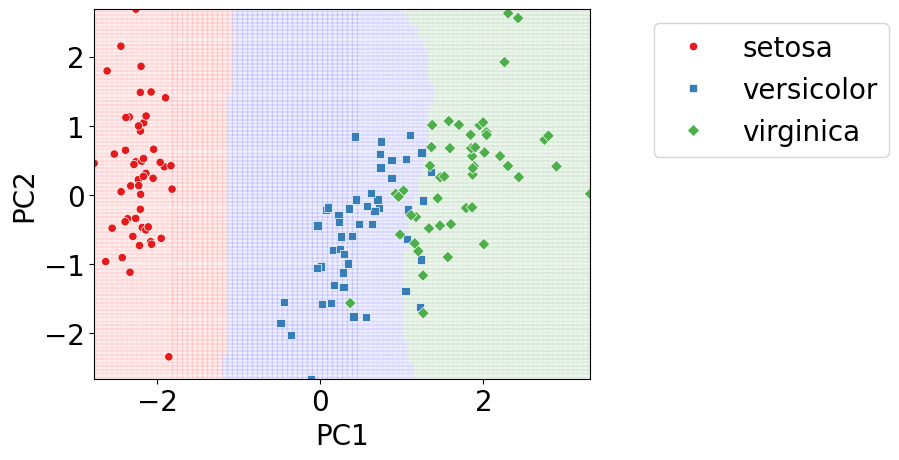

In [27]:
bg_x = np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100)
bg_y = np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
grid_x, grid_y = np.meshgrid(bg_x, bg_y)
grids = np.hstack([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)])

scaled_data = pca_df.values
train_X_Setosa = scaled_data[:, :-1][scaled_data[:, -1] == 0]
train_X_Versicolor = scaled_data[:, :-1][scaled_data[:, -1] == 1]
train_X_Virginica = scaled_data[:, :-1][scaled_data[:, -1] == 2]

# setosa vs the other two
s_vs_v_model = BinarySVM(kernel="linear", use_slacking=False,  c=0, solver=solver)
s_vs_v_model.solve(train_X=np.vstack([train_X_Setosa, train_X_Versicolor]), 
                   train_Y=np.array([1]*train_X_Setosa.shape[0] + [-1]*train_X_Versicolor.shape[0]))
pred_grid_vs = s_vs_v_model.predict(grids)
mask_1 = pred_grid_vs==-1 # needs to be further classified

# versicolor from virginica
v_vs_v_model = BinarySVM(kernel="linear", use_slacking=True,  c=0.1, solver=solver)
poly = PolynomialFeatures(degree=d)
poly_X = poly.fit_transform(np.vstack([train_X_Versicolor, train_X_Virginica]))
poly_Y = np.array([1]*train_X_Versicolor.shape[0] + [-1]*train_X_Virginica.shape[0])
v_vs_v_model.solve(train_X=poly_X, 
                   train_Y=poly_Y)
pred_grid_vv = v_vs_v_model.predict(poly.fit_transform(grids))
mask_2 = pred_grid_vv==-1

pred_grid_y = np.zeros_like(pred_grid_vs)
pred_grid_y[~mask_1] = 0
pred_grid_y[mask_1&(~mask_2)] = 1
pred_grid_y[mask_1&mask_2] = 2

## plot the full boundaries
color_map = {0: "red", 1: "blue", 2: "green"}
plt.scatter(grids[:, 0], grids[:, 1], c=[color_map[l] for l in pred_grid_y], \
    s=10, marker="s", alpha=0.05)
scatter = sns.scatterplot(data=pca_df, x="PC1", y="PC2", \
    hue="species", palette="Set1", style="species", markers=["o", "s", "D"])
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels = scatter.get_legend_handles_labels()
labels = [species_names[int(label)] for label in labels]
plt.xlim([pca_df["PC1"].min(), pca_df["PC1"].max()])
plt.ylim([pca_df["PC2"].min(), pca_df["PC2"].max()])
plt.legend(handles, labels, bbox_to_anchor=(1.1, 1))

# Future Perspectives

In the future, the binary SVM can be extended to multi-class SVM and enable the support for more kernel functions.

# References
Other than lecture notes of CS524, another important resource is [CS229 Lecture Notes: Kernel Methods](https://cs229.stanford.edu/notes2020fall/notes2020fall/cs229-notes3.pdf). This resource helps a lot on how to determining the bias term $\gamma$ from the dual problem solutions.